In [1]:
import torch
from torch import nn
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt

## 自注意力
---

In [2]:
def sequence_mask(X, valid_len, value=0):
    """在序列中遮蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None,:] < valid_len[:, None]
    X[~mask] = value
    return X

In [3]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    ## X: 3D张量 valid_lens: 1D或2D张量
    if valid_lens is None:
        return F.softmax(X, dim=-1)
    shape = X.shape
    if valid_lens.dim() == 1:
        valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else:
        valid_lens = valid_lens.reshape(-1)
    X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    return F.softmax(X.reshape(shape), dim=-1)

In [4]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    def forward(self, queries, keys, values, valid_lens=None):
        ## queries的形状: (batch_size, 查询个数, d)
        ## keys的形状: (batch_size, 键值对个数, d)
        ## values的形状: (batch_size, 键值对个数, 值的维度)
        ## valid_lens的形状: (batch_size,)或(batch_size, 查询个数)
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2))/math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [5]:
## 输入X形状: (batch_size, 查询或键值对个数, num_hiddens)
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)    ## (batch_size, 查询或键值对个数, num_heads, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3) ## (batch_size, num_heads, 查询或键值对个数, num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3]) ## (batch_size*num_heads, 查询或键值对个数, num_hiddens/num_heads)

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
    
    ## queries, keys, values的形状: (batch_size, 查询或键值对数, num_hiddens)
    ## valid_lens的形状: (batch_size,)或(batch_size, 查询的个数)
    def forward(self, queries, keys, values, valid_lens):
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0
            )
        output = self.attention(queries, keys, values, valid_lens)  ## (batch_size*num_heads, 查询个数, num_hiddens/num_heads)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [7]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(
    num_hiddens, num_hiddens, num_hiddens,
    num_hiddens, num_heads, 0.5
)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [8]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3,2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

## 比较卷积神经网络、循环神经网络和自注意力
---

## 位置编码
---

In [9]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1,1)/\
        torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32)/num_hiddens)
        self.P[:,:,0::2] = torch.sin(X)
        self.P[:,:,1::2] = torch.cos(X)
    def forward(self, X):
        X += self.P[:,:X.shape[1],:].to(X.device)
        return self.dropout(X)


In [10]:
def set_axes(axes, xlabel, ylabel, xscale, yscale, xlim, ylim):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.grid()

def plot(xs, ys, xlabel, ylabel, xlim=None, ylim=None, xscale='linear', yscale='linear', legend=None, figsize=(6, 3)):
    plt.rcParams['figure.figsize'] =figsize
    set_axes(plt.gca(), xlabel, ylabel, xscale, yscale, xlim, ylim)
    try:
        len(xs[0])
    except:
        xs = [xs]*len(ys)
    for x, y in zip(xs, ys):
        plt.plot(x, y)
    plt.legend(legend if legend else [])

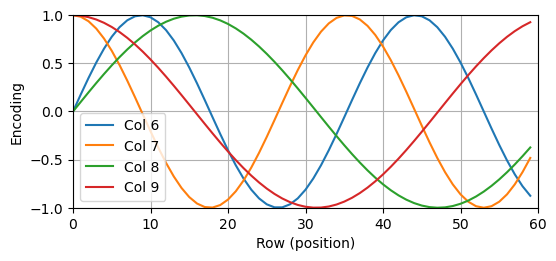

In [11]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1],:]
plot(torch.arange(num_steps), P[0,:,6:10].T, xlabel='Row (position)', ylabel='Encoding', xlim=[0, num_steps], ylim=[-1,1],
     figsize=(6, 2.5), legend=['Col %d' % d for d in torch.arange(6, 10)])
legend=['Col %d' % d for d in torch.arange(6, 10)]

In [12]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """显示矩阵热图"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows-1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

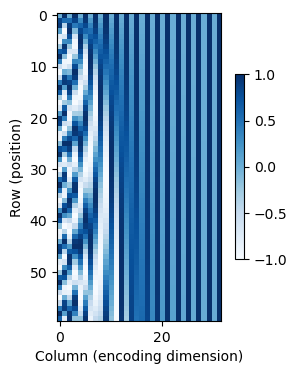

In [13]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

## Exercises
---

1. 假设设计一个深度架构，通过堆叠基于位置编码的自注意力层来表示序列。可能会存在什么问题？

2. 请设计一种可学习的位置编码方法